Plotting the location of each McDonald's in Switzerland
===============================

For when you need to know the closest way to get your burger fix.

Inspired by the code of Jake Vanderplas (jakevdp) https://gist.github.com/jakevdp/b0272667cae9c83e442e

Getting locations
-------------------

For this we want to scrape the McDonald's site for the longitude and latitude of every McDonald's in Switzerland.
We do it via the urllib3 package.

In [10]:
import urllib3
http = urllib3.PoolManager()
url = "http://www.mcdonalds.ch/fr/restaurantfinder?place=&page=" #This is the default form for the McDonalds pages

We now want to loop through each page until we reach the end. This is 33 pages, but in the future this might change, so check if there is a next page.

In [17]:
import numpy as np
import re
page_number = 1
latlon = np.empty([0,2])

while True: #We will break the loop when needed
    page = http.request('GET',url+str(page_number))
    data = page.data.split('\n')
    latlon = np.append(latlon, [re.findall('\d+.\d+',line) for line in data if "Test Case Coordinates" in line], axis=0)#Iteratively append
    page_number += 1
    if "next inactive" in page.data:
        break #No more pages
        
latlon = latlon.astype(np.float) #For ease we make it a float now

Plotting the results
-----------------------

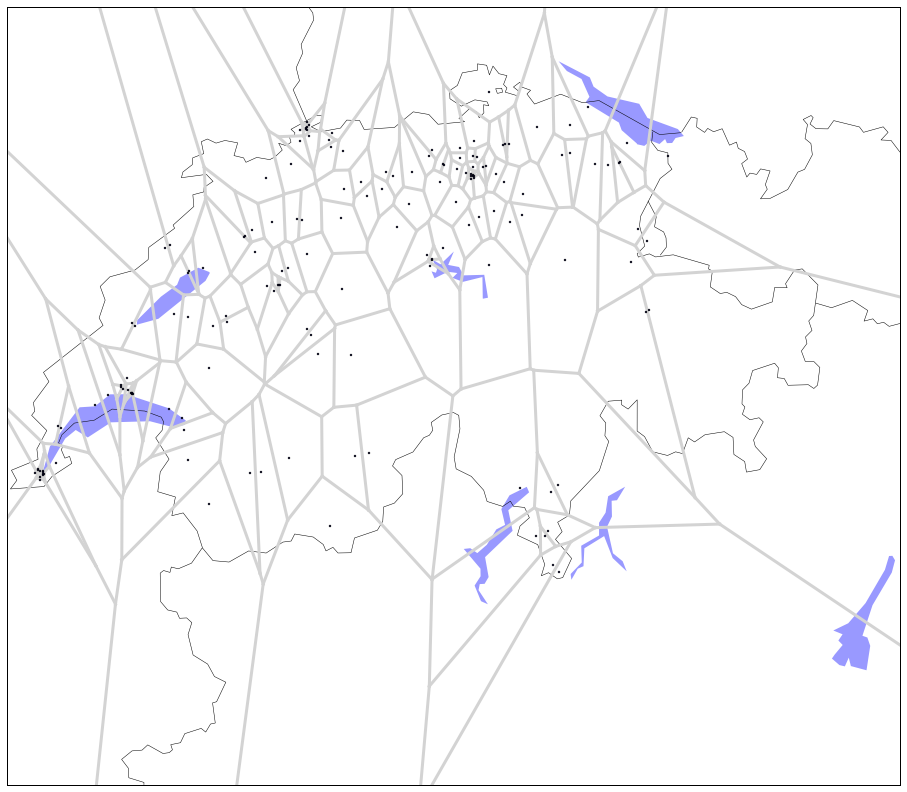

In [47]:
%matplotlib inline
import matplotlib.pyplot as plt
from mpl_toolkits.basemap import Basemap
from scipy.spatial import Voronoi

vor = Voronoi(latlon)
fig = plt.figure(figsize=(16,16))
m = Basemap(projection='aea', resolution='i',\
            llcrnrlon=6, urcrnrlon=11,\
            llcrnrlat=45, urcrnrlat=48,lat_0 = 46.5, lon_0 = 8.5,area_thresh=100)
m.fillcontinents(color='white', lake_color='#9999ff')
m.drawcountries(color='black')


#Need to plot the Voronoi diagram with basemap. Strictly speaking this isn't correct, the Voronoi point is on the plane, but isn't that bad.
for simplex in vor.ridge_vertices:
    simplex = np.asarray(simplex)
    if np.all(simplex >= 0):
        m.plot(vor.vertices[simplex,1],vor.vertices[simplex,0],color='lightgrey',latlon=True)
        
ptp_bound = vor.points.ptp(axis=0)
centre = vor.points.mean(axis=0)
for pointidx, simplex in zip(vor.ridge_points,vor.ridge_vertices):
    simplex = np.asarray(simplex)
    if np.any(simplex < 0):
        i = simplex[simplex >=0][0]
        t = vor.points[pointidx[1]] - vor.points[pointidx[0]]
        t /= np.linalg.norm(t)
        n = np.array([-t[1],t[0]])
        
        midpoint = vor.points[pointidx].mean(axis=0)
        direction = np.sign(np.dot(midpoint-centre,n)) * n
        far_point = vor.vertices[i] + direction*ptp_bound.max()
        
        m.plot([vor.vertices[i,1],far_point[1]],[vor.vertices[i,0],far_point[0]],color='lightgrey',latlon=True)
m.scatter(latlon[:,1],latlon[:,0],latlon=True,s=2,marker='o',alpha=0.9,zorder=3)
